In [2]:
from mangaki.utils.svd import MangakiSVD
from mangaki.utils.als import MangakiALS
from mangaki.utils.pca import MangakiPCA
from mangaki.utils.knn import MangakiKNN
import numpy as np
import pandas
from mangaki.utils.values import rating_values

ratings = pandas.read_csv('../data/ratings-ml.csv', header=None).as_matrix()
works = pandas.read_csv('../data/works-ml.csv', header=None).as_matrix()

In [3]:
svd = MangakiPCA(20)
X = ratings[:,0:2].astype(int)
# Y = [rating_values[rating] for rating in ratings[:,2]] # Mangaki
Y = [rating for rating in ratings[:,2]] # Movielens
nb_users = X[:,0].max() + 1
nb_items = X[:,1].max() + 1
svd.set_parameters(nb_users,nb_items)
svd.fit(X,Y)

from sklearn.metrics import mean_squared_error
mean_squared_error(svd.predict(X), Y)
# PCA 1.509
# KNN 1.159
# SVD 1.088
# ALS 0.821

0.83654836310611103

In [4]:
print(svd.predict(X)[:20])
print(Y[:20])

[ 3.63700734  3.62649663  3.6433236   3.63719043  3.64155642  3.62671834
  3.61853431  3.62725301  3.63015759  3.62725581  3.63283668  3.62177879
  3.6399311   3.62598001  3.62647401  3.64981411  3.63318533  3.62729403
  3.62705417  3.61526324]
[4.0, 1.5, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 0.5, 4.0, 0.5, 4.5, 1.5, 0.5, 4.0, 4.0, 4.5, 3.0, 2.5]


In [5]:
from collections import Counter
movies = Counter(X[:, 1])
popular = []
for work_id, v in movies.most_common(100):
    popular.append(work_id)
    print(works[work_id][1], v, 'votes')
popular.sort()

Pulp Fiction (1994) 325 votes
Forrest Gump (1994) 311 votes
Shawshank Redemption, The (1994) 308 votes
Jurassic Park (1993) 294 votes
Silence of the Lambs, The (1991) 290 votes
Star Wars: Episode IV - A New Hope (1977) 273 votes
Matrix, The (1999) 261 votes
Terminator 2: Judgment Day (1991) 253 votes
Braveheart (1995) 248 votes
Schindler's List (1993) 248 votes
Fugitive, The (1993) 244 votes
Toy Story (1995) 232 votes
Usual Suspects, The (1995) 228 votes
Star Wars: Episode V - The Empire Strikes Back (1980) 228 votes
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) 224 votes
Star Wars: Episode VI - Return of the Jedi (1983) 222 votes
Batman (1989) 217 votes
American Beauty (1999) 216 votes
Back to the Future (1985) 213 votes
Godfather, The (1972) 210 votes
Twelve Monkeys (a.k.a. 12 Monkeys) (1995) 207 votes
Fight Club (1999) 207 votes
Independence Day (a.k.a. ID4) (1996) 205 votes
Dances with Wolves (1990) 201 votes
Fargo (1996) 201 votes
Apollo 13 (1995) 

In [7]:
"""from scipy.spatial.distance import pdist, squareform

def compute_similarity_coisine(SVD):
    return 1 - squareform(pdist(SVD.T, metric='cosine'))"""

from mangaki.utils import dpplib
svd.VT.shape
#similarity = svd.VT

(20, 10325)

In [8]:
"""limit = 150
A=Work.objects.popular()[:limit]
liste=[np.argwhere(works== A[i].title)[0][0] for i in range(0,limit)]
svd.U.shape"""
svd.VT.shape

(20, 10325)

In [10]:
#liste de 10 éléments choisis en utilisant la dpp
similarity = svd.VT.T.dot(svd.VT)
#sampled_items = dpp.sample_k(liste, similarity, 5)

In [11]:
similarity.shape

(10325, 10325)

In [12]:
L = similarity[np.ix_(popular, popular)]
D, V = np.linalg.eig(L.T)
D = np.real(D)
V = np.real(V)

In [14]:
sampled_items = list(map(lambda x: popular[int(x)], dpplib.sample_k(5, D, V)))
for i in sampled_items:
    print(works[i, 1])

Aladdin (1992)
Mrs. Doubtfire (1993)
Groundhog Day (1993)
Saving Private Ryan (1998)
Pulp Fiction (1994)


In [15]:
X = svd.VT.T[np.array(sampled_items)]
# X = svd.VT.T[np.array(sampled_items)[np.array([0, 2, 3, 4, 7, 8])]]

In [16]:
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearRegression

clf = LogisticRegression(fit_intercept=False)
# clf = LinearRegression(fit_intercept=False)
clf.fit(X, [1, 1, 0, 0, 1])
#pred = clf.coef_[0]
predx, predy = clf.coef_[0][:2]
clf.predict_proba(X)

array([[ 0.49878715,  0.50121285],
       [ 0.49874555,  0.50125445],
       [ 0.50254882,  0.49745118],
       [ 0.50374561,  0.49625439],
       [ 0.49366342,  0.50633658]])

In [17]:
#clf.coef_
predx, predy

(0.019735315617398521, -0.021387541105625088)

In [18]:
JJ = 1587
"""JJ = 1587
RB = 188
jjx, jjy = svd.U[JJ,0], svd.U[JJ,1]
rbx, rby = svd.U[RB,0], svd.U[RB,1]"""

'JJ = 1587\nRB = 188\njjx, jjy = svd.U[JJ,0], svd.U[JJ,1]\nrbx, rby = svd.U[RB,0], svd.U[RB,1]'

<IPython.core.display.Javascript object>


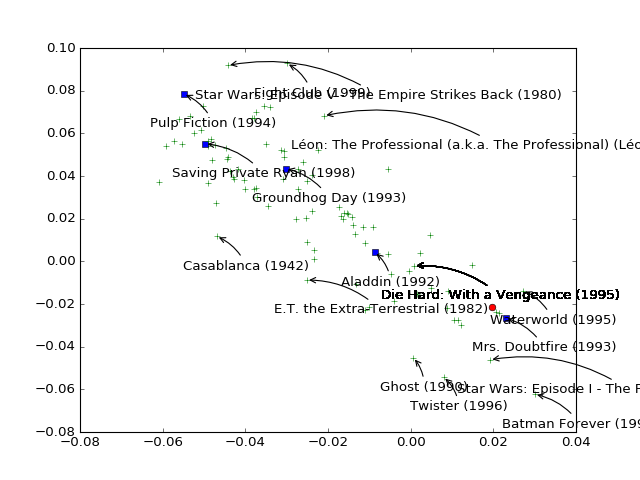

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt

class MangakiViz:
    label = None
    def __init__(self, titles, coords, drawn, featured):
        fig = plt.figure()
        self.label = {}
        for p_id in drawn:
            x, y = coords[p_id, 0], coords[p_id, 1]
            self.label[(x, y)] = titles[p_id]
            if p_id in featured:
                plt.plot(x, y, 'sb')  # Special points
                self.display(x, y)
            else:
                plt.plot(x, y, '+g', picker=5)
        # plt.plot(jjx, jjy, 'or')
        # plt.plot(predx, predy, 'og')
        fig.canvas.mpl_connect('pick_event', self.onpick)
    
    def display(self, x, y):
        plt.annotate(self.label[(x, y)], xy=(x, y), xycoords='data',
            xytext=(-30, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=.2")
            )
    
    def where_am_i(self, point):
        plt.plot(point[0], point[1], 'or')
    
    def draw_history(self, history):
        plt.plot(history[:, 0], history[:, 1], 'og')
    
    def onpick(self, event):
        thisline = event.artist
        xdata = thisline.get_xdata()
        ydata = thisline.get_ydata()
        ind = event.ind
        points = tuple(zip(xdata[ind], ydata[ind]))
        x, y = points[0]
        self.display(x, y)

titles = works[:, 1].tolist()
viz = MangakiViz(titles, svd.VT.T, popular, sampled_items)
# viz.where_am_i((-0.61951029531106994, -0.15674103238147402))  # Old Ryan
viz.where_am_i((clf.coef_[0][:2]))

In [55]:
jj = svd.U[JJ]
for work_id in sampled_items:
    print(titles[work_id], round(jj.dot(svd.VT.T[work_id]), 6))

Tengen Toppa Gurren Lagann -0.007899
Fairy Tail -0.538188
Le Château dans le ciel 0.802614
Death Note 0.438318
Yu-Gi-Oh! GX -0.469742


In [9]:
svd.VT = svd.VT_

In [15]:
u = pandas.read_csv('~/code/qna/notebooks/u.csv').as_matrix()
v = pandas.read_csv('~/code/qna/notebooks/v.csv').as_matrix()
history = pandas.read_csv('~/code/qna/notebooks/testlog.csv').as_matrix()

In [27]:
titles = v[:, 0].tolist()
coords = v[:, [1, 2]]
drawn = range(150)
featured = []
viz = MangakiViz(titles, coords, drawn, featured)
viz.where_am_i(u[1372][[1,2]])
viz.draw_history(history[:, [1, 2]])

TypeError: 'int' object is not subscriptable

In [131]:
predx, predy

(-0.61951029531106994, -0.15674103238147402)

In [86]:
contestants = list(zip(range(len(titles)), titles, clf.predict_proba(svd.VT.T)))
# contestants.sort(key=lambda x: abs(x[2][1] - 0.5))
contestants.sort(key=lambda x: x[2][0])

In [87]:
contestants[:150]  # Hai to Gensou no Grimgar

[(4692, 'Fullmetal Alchemist: Brotherhood', array([ 0.47216452,  0.52783548])),
 (5908, 'Fullmetal Alchemist', array([ 0.47536968,  0.52463032])),
 (2769, 'Clannad', array([ 0.47963831,  0.52036169])),
 (1239, 'Clannad: After Story', array([ 0.48216401,  0.51783599])),
 (5894, 'Angel Beats!', array([ 0.48639984,  0.51360016])),
 (2236,
  'Fullmetal Alchemist: Brotherhood OVA Collection',
  array([ 0.48786182,  0.51213818])),
 (898, 'Toradora!', array([ 0.48877736,  0.51122264])),
 (8078,
  'Clannad After Story: Another World, Kyou Chapter',
  array([ 0.49040025,  0.50959975])),
 (2676, 'Death Note', array([ 0.49061045,  0.50938955])),
 (3509, 'FullMetal Alchemist', array([ 0.49087285,  0.50912715])),
 (5147, 'Spice & Wolf', array([ 0.49166404,  0.50833596])),
 (2112, 'Spice & Wolf II', array([ 0.49182697,  0.50817303])),
 (3395, 'Clannad - Movie', array([ 0.49185913,  0.50814087])),
 (7851,
  'Clannad: Another World, Tomoyo Chapter',
  array([ 0.49202264,  0.50797736])),
 (6555, 'Elfen

In [192]:
class Data:
    def __init__(self):
        self.sampled_items = sampled_items.tolist()
        # self.X = svd.VT.T[self.sampled_items]
        self.y = [0, 1, 1, 1, 1]
    
    def get_all_ratings(self):
        self.sampled_items = []
        self.y = []
        rating_values = {'favorite': 1, 'like': 1}
        for user_id, work_id, choice in ratings:
            if user_id == JJ:
                self.sampled_items.append(work_id)
                self.y.append(rating_values.get(choice, 0))
        self.X = svd.VT.T[self.sampled_items]
        print(len(self.X), 'ratings')

    def add(self, extra):
        for work_id, outcome in extra:
            self.sampled_items.append(work_id)
            self.y.append(outcome)
        self.X = svd.VT.T[self.sampled_items]

# extra = [(332, 1), (2060, 1), (7726, 1)]
ryan = Data()
# ryan.add(extra)
ryan.get_all_ratings()
clf.fit(ryan.X, ryan.y)

519 ratings


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
import pprint

contestants = list(zip(titles, svd.VT[1, :]))
contestants.sort(key=lambda x: x[1])
print('Bottom 20')
pprint.pprint(contestants[:20])
print('Top 20')
pprint.pprint(contestants[-20:])

Bottom 20
[('Batman & Robin (1997)', -0.071479555237976555),
 ('Batman Forever (1995)', -0.062339356328242959),
 ('Anaconda (1997)', -0.061265098301348533),
 ('Johnny Mnemonic (1995)', -0.056055123715577998),
 ('Ace Ventura: When Nature Calls (1995)', -0.054605815337604932),
 ('Twister (1996)', -0.054268058423177362),
 ('Godzilla (1998)', -0.054193368340371632),
 ('Honey, I Shrunk the Kids (1989)', -0.053539310985434456),
 ('Crocodile Dundee II (1988)', -0.053506539790670764),
 ('Wild Wild West (1999)', -0.052991788797229662),
 ('Armageddon (1998)', -0.052913667310587331),
 ('Police Academy 6: City Under Siege (1989)', -0.050504185913203659),
 ('Speed 2: Cruise Control (1997)', -0.050410674165109554),
 ('Planet of the Apes (2001)', -0.049178786831054179),
 ('Broken Arrow (1996)', -0.048346855051642559),
 ('Mission: Impossible II (2000)', -0.047927744563459031),
 ('Police Academy 4: Citizens on Patrol (1987)', -0.047569022384734566),
 ('Pearl Harbor (2001)', -0.046790820467736534),
 ('S